# Vegetation detection

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_DATA, TRAIN_LABEL_TILES, get_image_tile_data, compute_mean_std_on_tiles
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2
import numpy as np
np.random.seed(2017)

### Input data

Images of shape (512, 512, 17) 

In [73]:
from unet import unet_one_test, unet_zero, unet_two, unet_one

In [55]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [56]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [57]:
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_DATA)+1:] for s in all_train_tiles])
print "First train tile : ", all_train_tiles[0]

if False:

    from sklearn.model_selection import train_test_split 

    # TRAIN ON N TILES
    n_tiles = -1
    if n_tiles > 0:
        train_tiles, val_tiles = train_test_split(all_train_tiles[:n_tiles], test_size=0.3)
    else:
        train_tiles, val_tiles = train_test_split(all_train_tiles, test_size=0.3)

    print "Train/Test : ", len(train_tiles), len(val_tiles)
    
    logging.getLogger().setLevel(logging.INFO)
    mean_tile_image, std_tile_image = compute_mean_std_on_tiles(train_tiles)
    logging.getLogger().setLevel(logging.WARN)
    
else:
    ll = int(len(all_train_tiles)*0.7)
    train_tiles = all_train_tiles[:ll]
    val_tiles = all_train_tiles[ll:]
    
    mean_tile_fname = os.path.join(TRAIN_DATA, 'mean_tile_image.npz')
    std_tile_fname = os.path.join(TRAIN_DATA, 'std_tile_image.npz')
    if not os.path.exists(mean_tile_fname) or not os.path.exists(std_tile_fname):
        logging.getLogger().setLevel(logging.INFO)
        mean_tile_image, std_tile_image = compute_mean_std_on_tiles(train_tiles)
        logging.getLogger().setLevel(logging.WARN)
        np.savez(mean_tile_fname, mean_tile_image)
        np.savez(std_tile_fname, std_tile_image)
    else:
        mean_tile_image = np.load(mean_tile_fname)['arr_0']
        std_tile_image = np.load(std_tile_fname)['arr_0']
        
    print mean_tile_image.shape, std_tile_image.shape

First train tile :  6010_1_2_0_0.tif
(256, 256, 17) (256, 256, 17)


In [58]:
def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out


def generate_images(train_tiles, batch_size, print_tile_id=False):
    while True:
        n = len(train_tiles)
        n_batches = n // batch_size
        random_indices = np.arange(n)
        np.random.shuffle(random_indices)
        for i in range(n_batches):
            end = min((i+1)*batch_size, n) 
            batch_indices = random_indices[batch_size*i:end]
            X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
            Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
            for j, tile_id in enumerate(train_tiles[batch_indices]):
                if print_tile_id:
                    print("Tile id: %s" % tile_id)
                x = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id))
                y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))
                
                if n_labels < len(LABELS) - 1:
                    y = y[:,:,labels]
                if n_channels < 17:
                    x = x[:,:,channels]

                x = normalize_image(x, mean_tile_image[:,:,channels], std_tile_image[:,:,channels])
                y = normalize_image(y)     
                
                X[j,:,:,:] = x
                Y[j,:,:,:] = y 
                
            yield (X, Y)

In [59]:
tile_size = (256, 256)
# channels = np.array(range(17))
channels = np.array([0, 1, 2, 3, 4])
n_channels = len(channels)

# labels = np.array(range(len(LABELS)))
labels = np.array([0, 5, 6, 2])
n_labels = len(labels)

Tile id: 6040_1_0_1280_3072.tif
Tile id: 6010_4_2_384_832.tif
Tile id: 6010_1_2_384_2624.tif
Tile id: 6060_2_3_2176_1728.tif
Tile id: 6010_4_4_1280_1728.tif
(5, 5, 256, 256) (5, 4, 256, 256)
-0.0142545 0.0703913 0.0 1.0


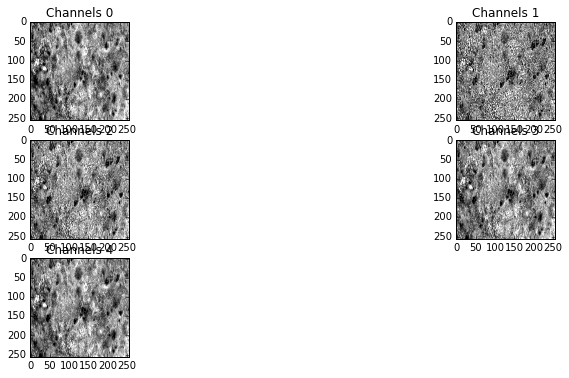

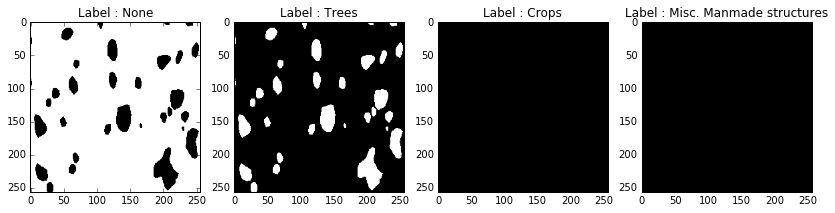

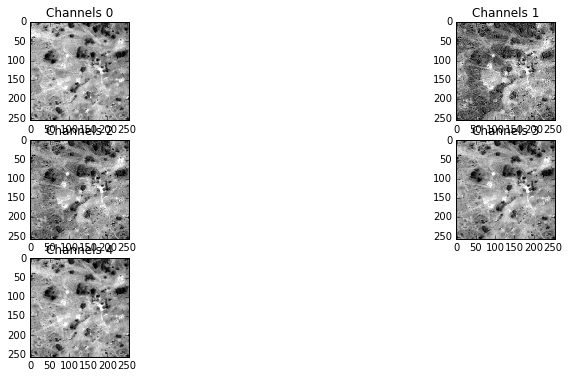

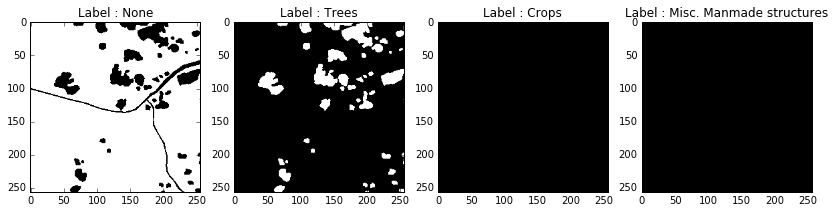

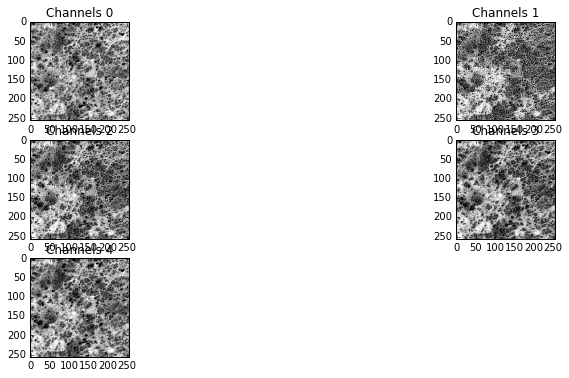

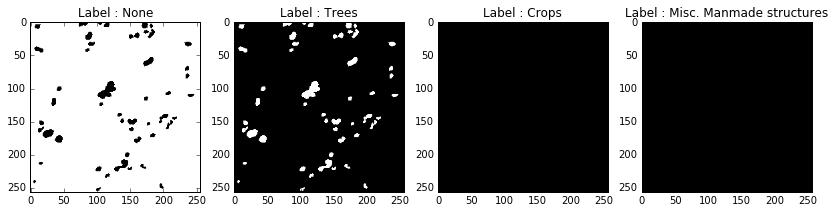

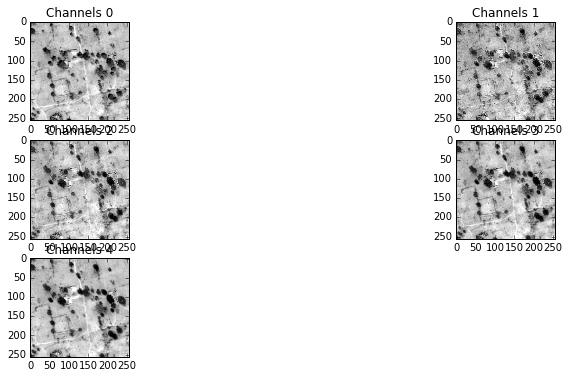

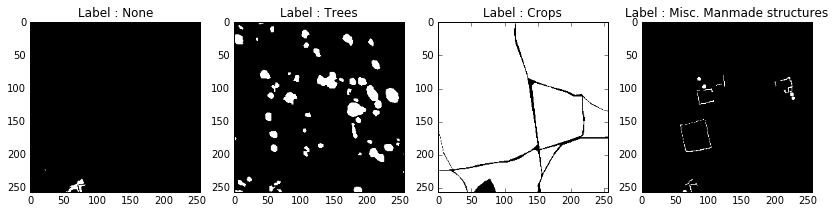

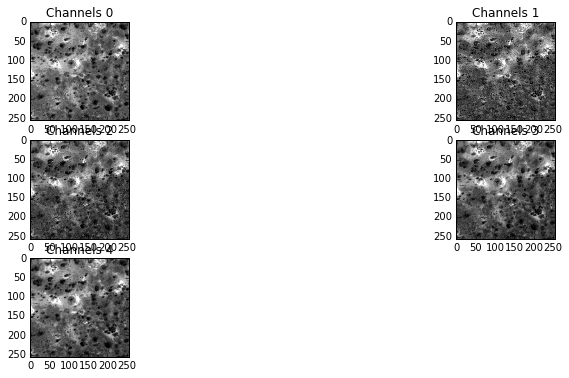

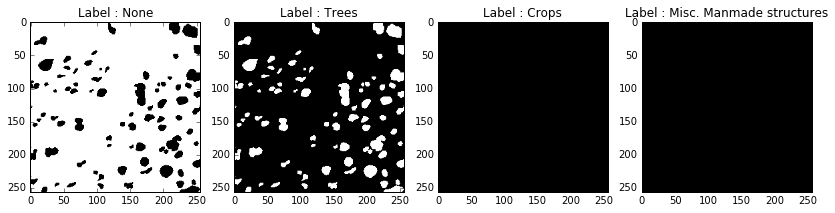

In [60]:
batch_size = 5
for X, Y in generate_images(train_tiles, batch_size, print_tile_id=True):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))
        n, m = 3, int(n_channels * 1.0 / 3.0 + 0.5), 
        for j in range(n_channels):
            plt.subplot(n,m,j+1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 0.5), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [61]:
import os
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

In [95]:
deep=True 
n_filters_0=8

model = unet_two(n_labels, n_channels, *tile_size, deep=deep, n_filters_0=n_filters_0)

# weights_filename = os.path.join("weights", "unet_two_%i_%i_%s_%i.h5" % (n_channels, n_labels, str(deep), n_filters_0))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [96]:
channels, labels, np.array(LABELS)[labels]

(array([0, 1, 2, 3, 4]),
 array([0, 5, 6, 2]),
 array(['None', 'Trees', 'Crops', 'Misc. Manmade structures'], 
       dtype='|S24'))

In [108]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 5, 256, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_243 (Convolution2D (None, 16, 256, 256)  736         input_14[0][0]                   
____________________________________________________________________________________________________
inverse_54 (Inverse)             (None, 16, 256, 256)  0           convolution2d_243[0][0]          
____________________________________________________________________________________________________
inverse_55 (Inverse)             (None, 16, 256, 256)  0           convolution2d_243[0][0]          
___________________________________________________________________________________________

In [98]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
# earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)
# LearningRateScheduler

In [99]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

model.compile(optimizer=Adadelta(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [100]:
# from keras.callbacks import RemoteMonitor
# rmon = RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})

In [ ]:
foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 16
samples_per_epoch = foo(len(train_tiles))
nb_val_samples = foo(len(val_tiles))


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_tiles, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=50,
    validation_data=generate_images(val_tiles, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

In [107]:
# model.save_weights(weights_filename)

If `nan` appears, analyse a single image model fit

In [87]:
batch_size = 10
for X, Y in generate_images(train_tiles, batch_size, print_tile_id=True):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()

    hist = model.fit(X, Y, batch_size=batch_size//2, nb_epoch=5, verbose=2)
    Y_pred = model.predict(X, batch_size=batch_size//2)
    print Y_pred.min(), Y_pred.max()
    break

Tile id: 6120_2_0_2624_1728.tif
Tile id: 6070_2_3_3072_384.tif
Tile id: 6070_2_3_0_0.tif
Tile id: 6120_2_2_0_384.tif
Tile id: 6040_4_4_832_1728.tif
Tile id: 6070_2_3_1280_832.tif
Tile id: 6040_4_4_384_1280.tif
Tile id: 6040_4_4_0_2176.tif
Tile id: 6040_4_4_384_3072.tif
Tile id: 6100_2_3_384_1280.tif
(10, 5, 256, 256) (10, 4, 256, 256)
-0.0639299 0.258386 0.0 1.0
Epoch 1/5
2s - loss: 334.9549 - jaccard_coef: 0.1616 - jaccard_coef_int: 0.2556 - acc: 0.0155
Epoch 2/5
2s - loss: 334.9538 - jaccard_coef: 0.1618 - jaccard_coef_int: 0.2452 - acc: 0.0161
Epoch 3/5
2s - loss: 334.9527 - jaccard_coef: 0.1610 - jaccard_coef_int: 0.2393 - acc: 0.0165
Epoch 4/5
2s - loss: 334.9517 - jaccard_coef: 0.1528 - jaccard_coef_int: 0.2305 - acc: 0.0166
Epoch 5/5
2s - loss: 334.9505 - jaccard_coef: 0.1541 - jaccard_coef_int: 0.2316 - acc: 0.0169
0.269869 0.721974


In [23]:
layer = model.get_layer(index=2)
print layer.weights
print layer.W.eval()[0,0,:,:]

layer = model.get_layer(index=1)
print layer.weights
print layer.W.eval()[0,0,:,:]
layer = model.get_layer(index=5)
print layer.weights
print layer.W.eval()[0,0,:,:]

[convolution2d_4_W, convolution2d_4_b]
[[ 0.20707504  0.11569368 -0.26223308]
 [-0.037168    0.14761208  0.18767962]
 [-0.03102852 -0.20170985 -0.04872162]]
[convolution2d_3_W, convolution2d_3_b]
[[ 0.22671278  0.2578637   0.17819569]
 [-0.00840357  0.07493455 -0.24825001]
 [ 0.14824052  0.03659624 -0.11134839]]
[convolution2d_5_W, convolution2d_5_b]
[[ 0.46003461]]


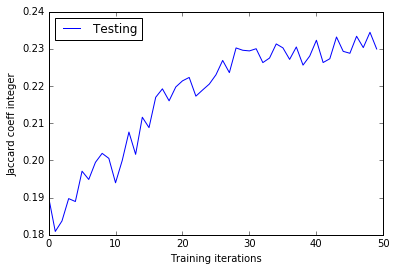

In [103]:
plt.plot(history.history['val_jaccard_coef_int'])
plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
# plt.plot(history.history['loss'])
# plt.ylabel('loss')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [27]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5, 4, 256, 256) 0.00888878 0.997656


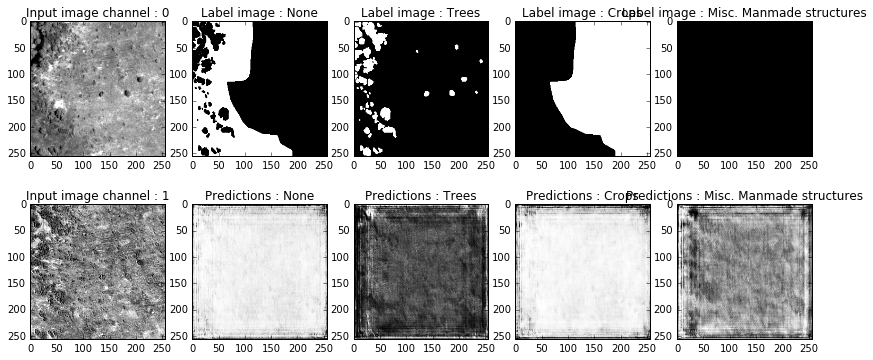

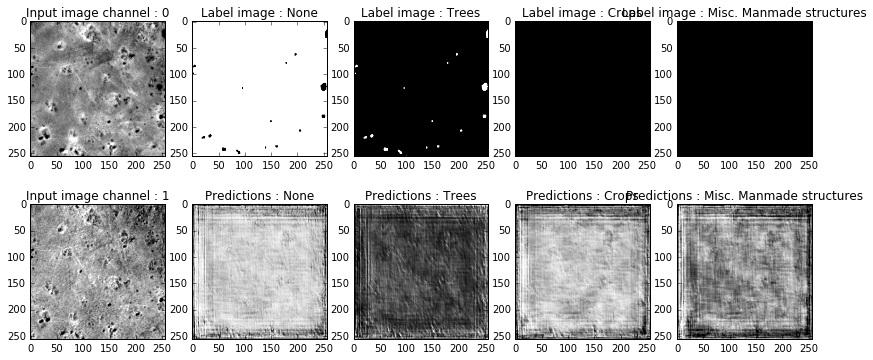

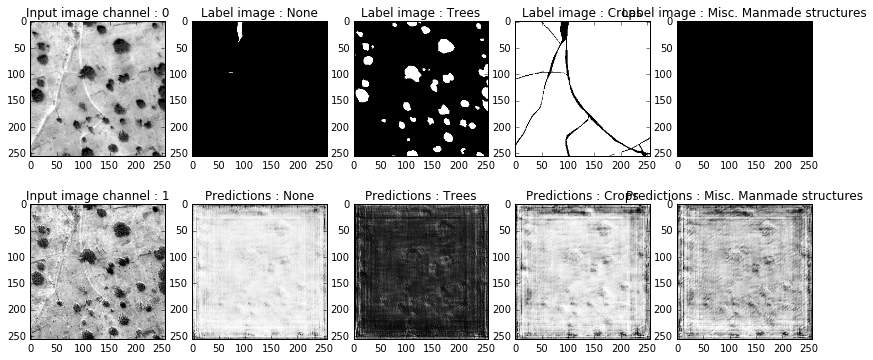

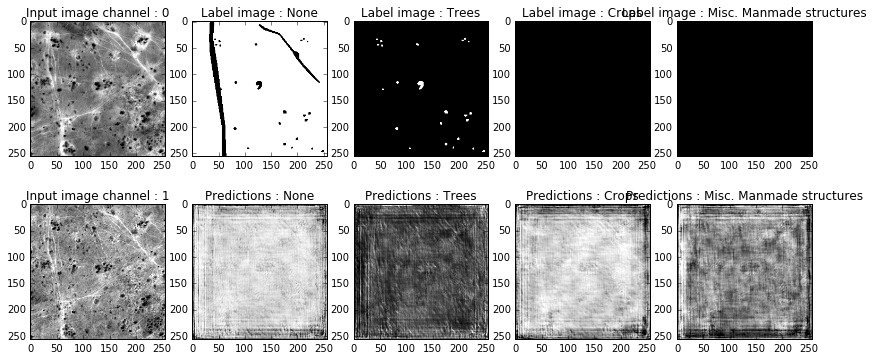

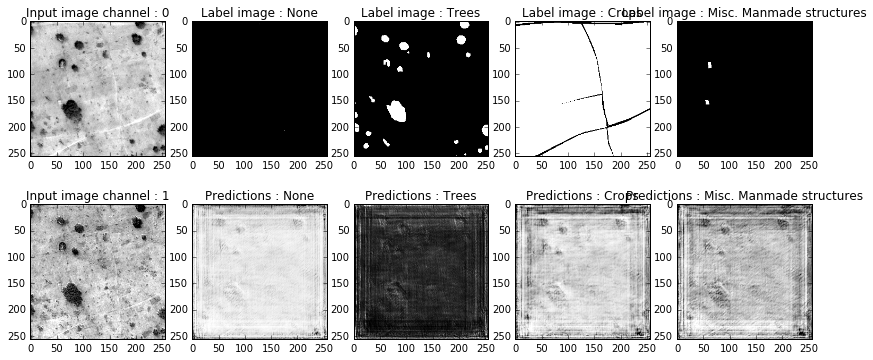

In [104]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


In [ ]:
_plot(X, Y, Y_pred, 0, 0)

In [ ]:
y = Y_pred[0,2,:,:]
print y.min(), y.max()